In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 930.5 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC, SVC
import random
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/IEEE-CIS/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1BUDjtdkbYP6ayadYsrcyHHHfPTJigLdc/IEEE-CIS


In [4]:
# load provided datasets
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# combine datasets as needed
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [5]:
# The dataset are sparse, only consider the features with less than 30% missing data
valid_cols = pd.DataFrame(train.isnull().sum()/len(train)*100 < 30)
valid_cols = valid_cols[valid_cols[0] == True]
train = train[list(valid_cols.index)]

In [6]:
# Seperate categorical variables
train = train.astype({'ProductCD': 'category',
                   'card1': 'category','card2': 'category','card3': 'category','card4': 'category','card5': 'category','card6': 'category',
                   'addr1': 'category','addr2': 'category',
                   'P_emaildomain': 'category',
                   'M6': 'category'})

In [7]:
# Fill missing values in numerical columns
num_cols = train.select_dtypes(include=np.number).columns.tolist()
for column in num_cols:
    train[column].fillna(train[column].median(), inplace=True)

In [8]:
# seperate X and Y
train_X = train.drop(columns=['isFraud'])
train_Y = train['isFraud']
X_dev, X_test, y_dev, y_test = train_test_split(train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=42)

In [9]:
# drop high correlated (>0.9) features
corr_matrix = X_dev.corr().abs()

# create a mask for highly correlated features
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.9)]
X_dev = X_dev.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

<ipython-input-9-f57138035e0b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_dev.corr().abs()


In [10]:
# Encoding and StandardScaler
num_cols = X_dev.select_dtypes(include=np.number).columns.drop(['TransactionID']).tolist()
te_cols = ['TransactionID','card1', 'card2', 'addr1', 'card5', 'card3', 'addr2', 'P_emaildomain']
cat_cols = X_dev.select_dtypes(exclude=np.number).columns.drop(['card1', 'card2', 'addr1', 'card5', 'card3', 'addr2', 'P_emaildomain']).tolist()
ohe_features = cat_cols
num_features = num_cols
te_features = te_cols

preprocess = make_column_transformer((StandardScaler(), num_features), (OneHotEncoder(handle_unknown='ignore'), ohe_features), (ce.TargetEncoder(return_df=True), te_features))
preprocess.fit(X_dev, y_dev)
X_dev = preprocess.transform(X_dev)
X_test = preprocess.transform(X_test)

In [11]:
# SMOTE
smote = SMOTE(random_state=42)
X_dev, y_dev = smote.fit_resample(X_dev, y_dev)

In [12]:
X_dev.shape

(911804, 125)

In [13]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.9 MB/s eta 0:00:00


In [14]:
import optuna
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression


# Objective function for XG Gradient Boosting Classifier
def xgb_objective(trial):
    
    n_estimators = trial.suggest_int("n_estimators", 1, 2000)
    eta = trial.suggest_float("eta", 1e-5, 1, log=True)
    gamma = trial.suggest_int("gamma", 1, 9)
    max_leaves = trial.suggest_int("max_leaves", 15, 127)
    
    hist_gb = XGBClassifier(n_estimators=n_estimators, eta=eta, gamma=gamma, max_leaves=max_leaves, random_state=42, tree_method='gpu_hist')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(hist_gb, X_dev, y_dev, cv=cv, scoring='roc_auc', n_jobs=-1)

    return np.mean(auc_scores)


# Hist Gradient Boosting Classifier Hyperparameter Tuning
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=10)  # Increase the number of trials to 10


best_xgb_params = xgb_study.best_params



/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
[I 2023-04-30 04:43:28,516] A new study created in memory with name: no-name-71f49b12-2c14-44cd-9c39-3e73947ad041
[I 2023-04-30 04:46:38,811] Trial 0 finished with value: 0.99831409437168 and parameters: {'n_estimators': 1439, 'eta': 0.05660118530689979, 'gamma': 1, 'max_leaves': 122}. Best is trial 0 with value: 0.99831409437168.
[I 2023-04-30 04:51:51,582] Trial 1 finished with value: 0.9726651361970443 and parameters: {'n_estimators': 1871, 'eta': 6.978651777108051e-05, 'gamma': 6, 'max_leaves': 101}. Best is trial 0 with value: 0.99831409437168.
[I 2023-04-30 04:52:49,863] Trial 2 finished with value: 0.9540746775912966 and parameters: {'n_est

In [16]:
xgb_clf = XGBClassifier(**best_xgb_params, random_state=42, tree_method='gpu_hist')

xgb_clf.fit(X_dev, y_dev)

# Predict on the test set
xgb_pred = xgb_clf.predict(X_test)

# Calculate evaluation metrics

xgb_precision = precision_score(y_test, xgb_pred)

xgb_recall = recall_score(y_test, xgb_pred)

xgb_avg_precision = average_precision_score(y_test, xgb_pred)

# Print evaluation metrics
print("XGB Classifier:")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"Average Precision-Recall: {xgb_avg_precision:.4f}")


XGB Classifier:
Precision: 0.8863
Recall: 0.5335
Average Precision-Recall: 0.4892


In [17]:
print("Best Hyperparameters: ", xgb_study.best_params)

Best Hyperparameters:  {'n_estimators': 1439, 'eta': 0.05660118530689979, 'gamma': 1, 'max_leaves': 122}


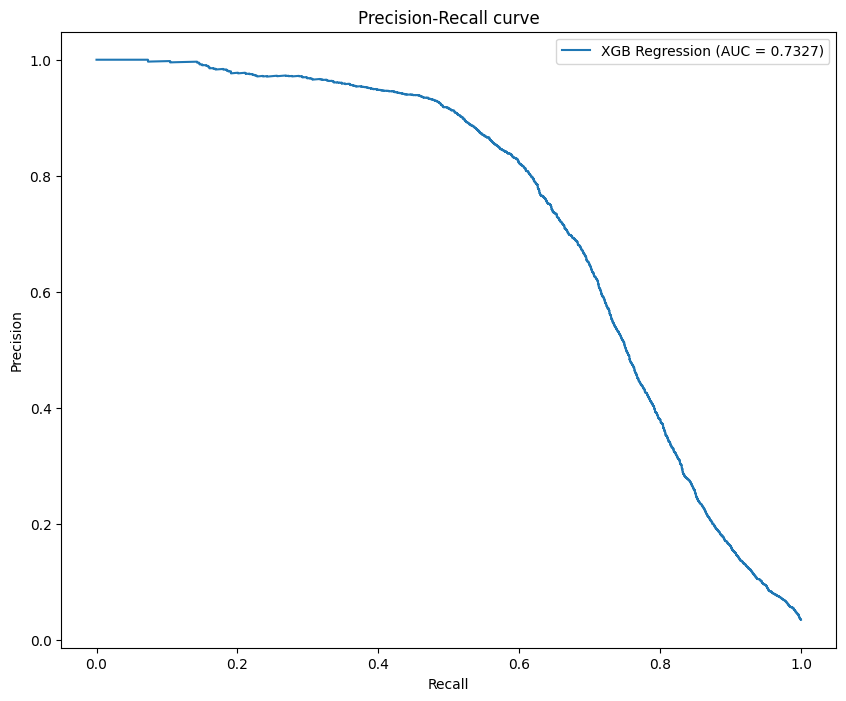

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Compute Precision-Recall curve
xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_prob)

# Compute the AUC of the Precision-Recall curve
xgb_pr_auc = auc(xgb_recall, xgb_precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(xgb_recall, xgb_precision, label=f'XGB Regression (AUC = {xgb_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

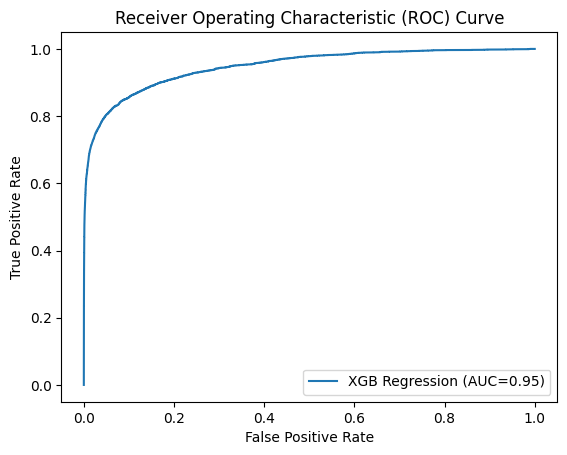

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb, pos_label=1)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.plot(fpr_xgb, tpr_xgb, label=f'XGB Regression (AUC={auc_xgb:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.89      0.53      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.93      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108



In [21]:
import numpy as np

np.save('fpr_xgb.npy', fpr_xgb)
np.save('tpr_xgb.npy', tpr_xgb)